In [1]:
using QuantumOptics
using PyPlot
using Statistics
using Random
using JLD2
using CollectiveSpins
using ProgressMeter

In [2]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array, system, Nsys)
    phi_array = zeros(Nsys)
    for i = 1:Nsys
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

function avgSz(rho)
    Sz = [CollectiveSpins.mpc.sz(ρ) for ρ in rho]
    meanSz = [mean(subarray) for subarray in Sz]
    return  -1 .*(meanSz.+1) ./2 .- 6 # Map to real spin values

end
 
function calcEvolutionMPC(λl, θl, Tstep, Tend, theta_init, phi_init)
    a,b,c = [d_xy,d_xy,d_z]/λl
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)

    theta_array = ones(N)*theta_init
    phi_array = prepare_phi_IS(θl, λl, theta_array, system, N)*phi_init
    Ψ0 = CollectiveSpins.mpc.blochstate(phi_array, theta_array)

    tout, ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)
    meanSz = avgSz(ρt)
    return meanSz
end

function calcSE_MPC(Tstep, Tend, phi_init, theta_init)
    a,b,c = [266.,266.,532.]
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)
    
    Ψ0 = CollectiveSpins.independent.blochstate(phi_init, theta_init, N)
    tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0, dt=Tstep)
    Sz = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
    meanSz_ind = [mean(subarray) for subarray in Sz]
    return -1 .*(meanSz_ind.+1) ./2 .- 6 # Map to real spin values
end

calcSE_MPC (generic function with 1 method)

# SR criterium: Initial and max slope

### Defining the system

In [3]:
# Define the system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.

# Define normalization variables
λ = 1299.
θl_array = range(0, pi/2, 50) # Angles of the laser

# Define the geometry
a_dim,b_dim,c_dim = [d_xy,d_xy,d_z]/λ
geo = CollectiveSpins.geometry.box(a_dim,b_dim,c_dim;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis

Γ0 = 1.

# Initial values
theta_init = pi/2
phi_init = 1 # 1 if laser induced correlations between the atoms, 0 else

Tstep, Tend = 1e-3, 1 # Normalised time (t/τ)
T = [0:Tstep:Tend;];

# Plot QC sols

In [4]:
close("all")
figure()

for θl in θl_array
    @load "Solutions/Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))" sol;
    mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
    mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6;
    plot(T, mean_σz67_QC, label=string((round(θl, digits=2))))
end
legend()

pygui(false); gcf();

### Load QC

In [5]:
diff_init = []
for θl in θl_array
    @load "Solutions/Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))" sol
    mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:2]
    mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6
    push!(diff_init, diff(mean_σz67_QC)[1]/Tstep)
end

### Compute CS

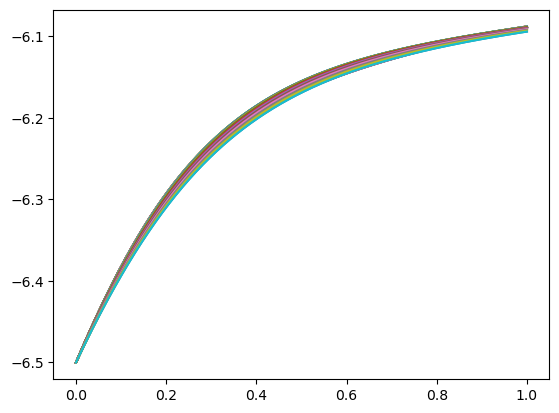

In [6]:
# Plot CS sim
close("all"); figure()
for θl in θl_array
    plot(T, calcEvolutionMPC(λ, θl, Tstep, Tend, theta_init, phi_init))
end
gcf()

In [7]:
diff_init_CS = []
@showprogress for θl in θl_array
    push!(diff_init_CS, diff(calcEvolutionMPC(λ, θl, Tstep, Tend, theta_init, phi_init))[1]/Tstep)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


### Compute the independent case

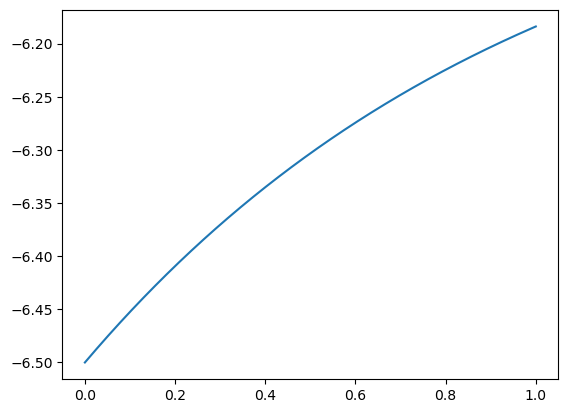

In [8]:
# Plot indep case
close("all"); figure()
plot(T, calcSE_MPC(Tstep, Tend, 1., theta_init))
gcf()

In [9]:
diff_meanSz_SE_t0 = diff(calcSE_MPC(Tstep, Tend, 1., theta_init))[1]/Tstep;

# Plot the initial slope

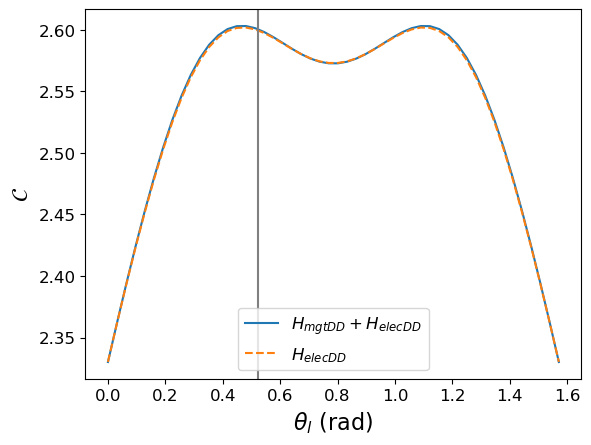

In [11]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(θl_array, diff_init/diff_meanSz_SE_t0, label=L"$H_{mgtDD}+H_{elecDD}$")
plot(θl_array, diff_init_CS/diff_meanSz_SE_t0, label = L"$H_{elecDD}$", linestyle="--")

axvline(30*pi/180, color="grey")

legend()

xlabel(L"$\theta_l$ (rad)", fontsize=16)
ylabel(L"\mathcal{C}", fontsize=16) # = \frac{\partial_t\langle\sigma^z\rangle}{\partial_t\langle\sigma^z_{idp}\rangle}(t=0)

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/ComparisonSR_criterium(theta_l)_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init).pdf", bbox_inches="tight")

pygui(false); gcf()